## Loading and Plotting Test Accuracies and Losses

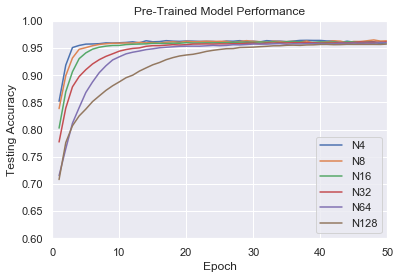

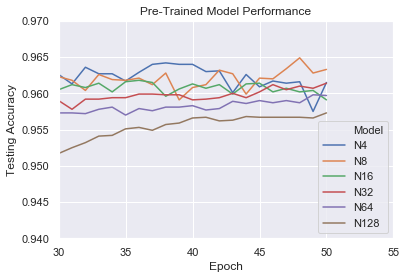

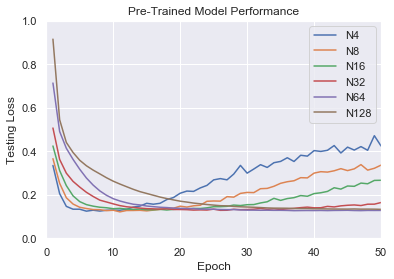

In [8]:
import numpy as np
ModelList = ['N4','N8','N16','N32','N64','N128']

# Initialize variables and preallocate memory space
Epochs = 50
ModelCt = len(ModelList)
TestAccuracies = np.zeros([5*ModelCt,Epochs])
TestLosses = np.zeros([5*ModelCt,Epochs])

# Import CSV data from feature extraction architecture experiments
for i in range(ModelCt):
    TestAccuracies[i*5:(i+1)*5,:] = np.genfromtxt('BatchSize/'+str(ModelList[i][1:])+'_TestAcc.csv', delimiter=',')
    TestLosses[i*5:(i+1)*5,:] = np.genfromtxt('BatchSize/'+str(ModelList[i][1:])+'_TestLoss.csv', delimiter=',')
    
# Flatten or concatenate data for dataframe
All_Accuracies = TestAccuracies.flatten()
All_Losses = TestLosses.flatten()
Epochs = np.array(list(np.arange(1,Epochs+1))*5*ModelCt)
Models = np.repeat(ModelList, [250]*ModelCt, axis=0)

import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# Set up DataFrame for testing accuracy and testing loss
AccuracyPerformanceData = {'Epoch': Epochs, 'Testing Accuracy': All_Accuracies, 'Model': Models}
AccuracyPerformanceDf = pd.DataFrame(data=AccuracyPerformanceData)

LossPerformanceData = {'Epoch': Epochs, 'Testing Loss': All_Losses, 'Model': Models}
LossPerformanceDf = pd.DataFrame(data=AccuracyPerformanceData)

# Print plots 
plt.figure(1)
AccuracyPerformancePlt = sns.lineplot(x="Epoch", y="Testing Accuracy", hue="Model", ci = None, data=AccuracyPerformanceData)
plt.title('Pre-Trained Model Performance')
plt.ylabel('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.6,1) 
plt.xlim(0,50)
#plt.savefig('TestAccuracyGraph.png', dpi = 600)
plt.show()

plt.figure(2)
AccuracyPerformancePlt = sns.lineplot(x="Epoch", y="Testing Accuracy", hue="Model", ci = None, data=AccuracyPerformanceDf[AccuracyPerformanceDf.Epoch >=30])
plt.title('Pre-Trained Model Performance')
plt.ylabel('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.94,0.97) 
plt.xlim(30,55)
#plt.savefig('ZoomInTestAccuracyGraph.png', dpi = 600)
plt.show()

plt.figure(3)
LossPerformancePlt = sns.lineplot(x="Epoch", y="Testing Loss", hue="Model", ci = None, data=LossPerformanceData)
plt.title('Pre-Trained Model Performance')
plt.ylabel('Testing Loss')
plt.xlabel('Epoch')
plt.ylim(0,1) 
plt.xlim(0,50)
#plt.savefig('TestLossGraph.png', dpi = 600)
plt.show()

## Calculate Other Performance Measures
Sensitivity, Specificity, Positive Predictivity, Negative Predictivity, AUC, F1 Score, MCC Score

In [6]:
# Import library
from statistics import mean
from statistics import stdev
import csv
from sklearn import metrics

# List of models to examine
Model = ['N4','N8','N16','N32','N64','N128']

# Find TPR and FPR values closest to 0.5 threshold
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

for j in range(len(Model)):

    # Calculate relevant measurements at threshold = 0.5
    Ind,  F1,   MCC, Acc  = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
    Sens, Spec, PPV, NPV  = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
    TP,   TN,   FN,  FP   = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
    AUC = [0,0,0,0,0]

    # Load thresholds
    with open('BatchSize/'+Model[j][1:]+'_Thresholds.csv', newline='') as f:
        Th = list(csv.reader(f))
    for i in range(5):
        Th[i] = list(map(float, Th[i])) 

    # Load TPR
    with open('BatchSize/'+Model[j][1:]+'_TPR.csv', newline='') as f:
        TPR = list(csv.reader(f))
    for i in range(5):
        TPR[i] = list(map(float, TPR[i])) 

    # Load FPR
    with open('BatchSize/'+Model[j][1:]+'_FPR.csv', newline='') as f:
        FPR = list(csv.reader(f))
    for i in range(5):
        FPR[i] = list(map(float, FPR[i])) 

    # Find index at 0.5 threshold
    for i in range(5):
        AUC[i] = metrics.auc(FPR[i],TPR[i])
        Ind[i] = find_nearest_index(Th[i], 0.5)
        Sens[i] = TPR[i][Ind[i]]
        Spec[i] = 1-FPR[i][Ind[i]]
        Acc[i] = (Sens[i]+Spec[i])/2
        TP[i] = np.round(Sens[i]*5000)
        TN[i] = np.round(Spec[i]*5000)
        FN[i] = 5000-TP[i]
        FP[i] = 5000-TN[i]
        PPV[i] = TP[i]/(TP[i]+FP[i])
        NPV[i] = TN[i]/(TN[i]+FN[i])
        F1[i] = 2*PPV[i]*Sens[i]/(PPV[i]+Sens[i])
        MCC[i] = (TP[i]*TN[i]-FP[i]*FN[i])/((TP[i]+FP[i])*(TP[i]+FN[i])*(TN[i]+FP[i])*(TN[i]+FN[i]))**(0.5)

    # Print out results
    print('Model:',Model[j])
    print('Accuracy:',round(mean(Acc),4),'+',round(stdev(Acc),4))
    print('AUC:',round(mean(AUC),4),'+',round(stdev(AUC),4))
    print('Sensitivity:',round(mean(Sens),4),'+',round(stdev(Sens),4))
    print('Specificity:',round(mean(Spec),4),'+',round(stdev(Spec),4))
    print('PPV:',round(mean(PPV),4),'+',round(stdev(PPV),4))
    print('NPV:',round(mean(NPV),4),'+',round(stdev(NPV),4))
    print('F1:',round(mean(F1),4),'+',round(stdev(F1),4))
    print('MCC:',round(mean(MCC),4),'+',round(stdev(MCC),4))
    print('')

Model: N4
Accuracy: 0.9614 + 0.0031
AUC: 0.9878 + 0.0021
Sensitivity: 0.959 + 0.0093
Specificity: 0.9638 + 0.0104
PPV: 0.9638 + 0.0097
NPV: 0.9594 + 0.0085
F1: 0.9613 + 0.003
MCC: 0.923 + 0.0061

Model: N8
Accuracy: 0.9632 + 0.0035
AUC: 0.9894 + 0.0008
Sensitivity: 0.962 + 0.0084
Specificity: 0.9645 + 0.0093
PPV: 0.9645 + 0.0088
NPV: 0.9622 + 0.0079
F1: 0.9632 + 0.0035
MCC: 0.9266 + 0.0071

Model: N16
Accuracy: 0.9587 + 0.0034
AUC: 0.9899 + 0.002
Sensitivity: 0.9556 + 0.0038
Specificity: 0.9618 + 0.0105
PPV: 0.9617 + 0.0099
NPV: 0.9559 + 0.0033
F1: 0.9586 + 0.0031
MCC: 0.9175 + 0.0068

Model: N32
Accuracy: 0.9612 + 0.0022
AUC: 0.9915 + 0.0011
Sensitivity: 0.9568 + 0.0027
Specificity: 0.9656 + 0.0071
PPV: 0.9653 + 0.0068
NPV: 0.9572 + 0.0023
F1: 0.961 + 0.0021
MCC: 0.9224 + 0.0046

Model: N64
Accuracy: 0.9592 + 0.0036
AUC: 0.9915 + 0.0011
Sensitivity: 0.9474 + 0.0018
Specificity: 0.971 + 0.0079
PPV: 0.9704 + 0.0078
NPV: 0.9487 + 0.0016
F1: 0.9587 + 0.0035
MCC: 0.9187 + 0.0075

Model: N1

## Generate ROC Curves
We will not generate neat plots for this since the ROC is too good to be worth plotting anyways. It'll just all look like a bunch of sharp corners. It is sufficient to just report sensitivity and specificity. 